# 2. Simulate V1 neurons
* This notebook contains code for generating V1 neurons spike trains from stimulus and Gabor filters.
* The simulated V1 neurons are generated via Gabor-based models. 


* The process is broken into three steps: `response` $\to$ `firing rate` $\to$ `spike train`
1. Generate Gabor filter response to video
2. Convert response to firing rate.
3. Use Inhomogeneous Poisson process to generate spike train.

* This notebook goes through the above process step-by-step. It also allows the user to play around with the parameters for the function converting `response` to `firing rate`.
* For large number of Gabor filters, run the script `Gabor_response_multiprocessing.py`, which performs steps 1 to 3 in a distributed manner. 

<b> training & simulation stimulus </b>
* Recall that we generated two stimulus videos: one for training the neural network for `f_orientation`, `f_direction`, and one for actual simulation.
* We only need the response for the training video, but we need the spike trains for the actual simulation video. 
* In the end, we need the following outputs:
    * `firing rate` of Gabor filters to training video.
    * `spike train` of Gabor filters to simulation video.


In [11]:
import sys
sys.path.insert(0, '../../../src/')
import Gabor_response_multiprocessing as grm
from Gabor_filter_functions import *
from stimulus_helper import *
from simulations import *
import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import combinations
from scipy.signal import correlate
import pickle5 as pickle

In [7]:
from numpy.random import seed
seed(1)

In [8]:
directory = "../data"

In [ ]:
%matplotlib inline

# 1. Load stimulus video parameters

* Recall: Stimulus was generated by running script `generate_stimulus.py`, and Gabor filters were generated by running script `Gabor_filter_functions.py`

Load parameters of the stimulus videos

In [12]:
# load stimulus image parameters
with open(directory + '/stimulus_param.pickle', 'rb') as f:
    stimulus_param = pickle.load(f)
    
wavelength_stimulus = stimulus_param["wavelength"]
radius_stimulus = stimulus_param["radius"]
phase_stimulus = stimulus_param["phase"]
size_stimulus = stimulus_param["size"]

# load video parameters
with h5py.File(directory + "/stimulus.h5", "r") as f:
    train_orientations = np.array(f["train_stimulus"]["video_orientations"])
    train_locations = np.array(f["train_stimulus"]["video_locations"])
    simulation_orientations = np.array(f["simulation_stimulus"]["video_orientations"])
    simulation_locations = np.array(f["simulation_stimulus"]["video_locations"])

Create the stimulus videos 

In [9]:
from cv2 import VideoWriter, VideoWriter_fourcc

In [10]:
def generate_video(stimulus, title, FPS = 2):
    # stimulus: 3d stimulus
    # generate a video where each frame corresponds to stimulus[:,:,i]
    
    width, height, n_frames = stimulus.shape
    
    # NOTE: the dtype uint8 is very important!! 
    scaled = ((stimulus+1) * 255/2).astype(np.uint8)
    
    fourcc = VideoWriter_fourcc(*'MP42')
    video_title = './' + title + '.avi'
    video = VideoWriter(video_title, fourcc, float(FPS), (width, height), 0)
    
    for i in range(n_frames):
        frame = scaled[:,:,i]
        video.write(frame)
    video.release()

In [5]:
# generate stimulus videos
n_frames =  train_orientations.shape[0]


# create train video
train_video = create_stimulus_video(wavelength_stimulus, 
                                     phase_stimulus, 
                                     radius_stimulus, 
                                     size_stimulus, 
                                     n_frames, 
                                     train_locations, 
                                     train_orientations)


# create simulation video
simulation_video = create_stimulus_video(wavelength_stimulus, 
                                         phase_stimulus, 
                                         radius_stimulus, 
                                         size_stimulus, 
                                         n_frames, 
                                         simulation_locations, 
                                         simulation_orientations)

In [8]:
print("train video size: ", train_video.shape)
print("simulation video size: ", simulation_video.shape)

train video size:  (40, 40, 40000)
simulation video size:  (40, 40, 40000)


In [ ]:
# save video
generate_video(train_video[:,:,:100], directory + '/train_video', FPS = 25)

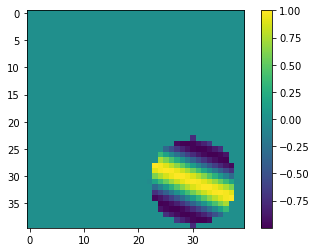

In [9]:
%matplotlib inline
i = 10
plt.imshow(train_video[:,:,i])
plt.colorbar()
plt.show()

# 2. Create simulated V1 neurons via Gabor filters

In [13]:
# Generate Gabor filters and save.
### Default parameters of Gabor filters ----------------------------------
n_orientations = 8
orientations_V1 = [x * math.pi / n_orientations for x in range(n_orientations)]
n_filters = 100 # number of filters per orientation

# use same image parameters as stimulus
size_V1 = size_stimulus
wavelength_V1 = wavelength_stimulus
radius_V1 = radius_stimulus
phase_V1 = phase_stimulus
sigma_V1 = 5
gamma_V1 = 1
#------------------------------------------------------------------------------

# User inputs number of Gabor filters per orientation
print('Total number of Gabor filters: ', n_orientations * n_filters)

df_Gabor = pd.DataFrame(columns = ['orientation', 'location_x', 'location_y'])

for ori in orientations_V1:
    # sample Gabor filter locations
    Gabor_locations = Gabor_filters_sample_accept(size_V1, n_filters)

    df_Gabor_sub = create_Gabor_filters_info(size_V1, wavelength_V1, sigma_V1, gamma_V1, [ori], Gabor_locations)
    df_Gabor = pd.concat([df_Gabor, df_Gabor_sub])

df_Gabor.reset_index(inplace = True)

# SAVE
"""
f = h5py.File(directory + '/V1_neurons.h5','a')
# create group for Gabor filters
grp = f.create_group('V1')
grp.create_dataset('orientations', data = df_Gabor.orientation.tolist())
grp.create_dataset('location_x', data = df_Gabor.location_x.tolist())
grp.create_dataset('location_y', data = df_Gabor.location_y.tolist())
grp.attrs['size'] = size_V1
grp.attrs['wavelength'] = wavelength_V1
grp.attrs['phase'] = phase_V1
grp.attrs['sigma'] = sigma_V1
grp.attrs['gamma'] = gamma_V1
grp.attrs['orientations'] = orientations_V1
f.close()
"""

Total number of Gabor filters:  800


"\nf = h5py.File(directory + '/V1_neurons.h5','a')\n# create group for Gabor filters\ngrp = f.create_group('V1')\ngrp.create_dataset('orientations', data = df_Gabor.orientation.tolist())\ngrp.create_dataset('location_x', data = df_Gabor.location_x.tolist())\ngrp.create_dataset('location_y', data = df_Gabor.location_y.tolist())\ngrp.attrs['size'] = size_V1\ngrp.attrs['wavelength'] = wavelength_V1\ngrp.attrs['phase'] = phase_V1\ngrp.attrs['sigma'] = sigma_V1\ngrp.attrs['gamma'] = gamma_V1\ngrp.attrs['orientations'] = orientations_V1\nf.close()\n"

In [15]:
# load Gabor filters
with h5py.File(directory + "/V1_neurons.h5", "r") as f:
    V1_orientations = np.array(f["V1"]["orientations"]).tolist()
    V1_location_x = np.array(f["V1"]["location_x"]).tolist()
    V1_location_y = np.array(f["V1"]["location_y"]).tolist()

# Generate Gabor filters and save.
### Default parameters of Gabor filters ----------------------------------
n_orientations = 8
orientations_V1 = [x * math.pi / n_orientations for x in range(n_orientations)]
n_filters = 100 # number of filters per orientation

# use same image parameters as stimulus
size_V1 = size_stimulus
wavelength_V1 = wavelength_stimulus
radius_V1 = radius_stimulus
phase_V1 = phase_stimulus
sigma_V1 = 5
gamma_V1 = 1

Generate images (Gabor filters) for V1

In [16]:
# generate Gabor filter images
n_V1 = 800

# from dataframe df_Gabor
#orientation_V1 = df_Gabor.orientation.tolist()
#V1_locx = df_Gabor.location_x.tolist()
#V1_locy = df_Gabor.location_y.tolist()



V1_img = np.zeros((size_V1, size_V1, n_V1))
for i in range(n_V1):

    real, _, _ = create_gabor_filter(size_V1//2, size_V1//2, wavelength_V1, V1_orientations[i], phase_V1, sigma_V1, gamma_V1, size_V1)

    change_x = V1_location_x[i] - size_V1//2
    change_y = V1_location_y[i] - size_V1//2

    new_img, _, _ = grm.move_img(real, size_V1//2, size_V1//2, change_x, change_y)
    V1_img[:,:,i] = -new_img

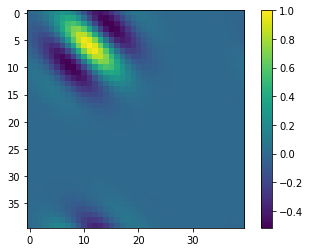

In [20]:
# select V1 neuron
i= 600
plt.imshow(V1_img[:,:,i])
plt.colorbar()
plt.show()

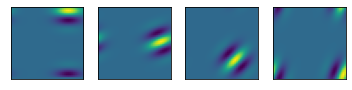

In [20]:
# plot example Gabor filters
fig, ax = plt.subplots(ncols = 4)
ax[0].imshow(V1_img[:,:,15])
ax[1].imshow(V1_img[:,:,115])
ax[2].imshow(V1_img[:,:,255])
ax[3].imshow(V1_img[:,:,355])

for a in ax:
    a.set_xticks([])
    a.set_yticks([])
plt.show()

In [78]:
i = 15
Gabor_torus, _, _ = create_gabor_filter_torus(V1_location_x[i], V1_location_y[i], wavelength_V1, V1_orientations[i], phase_V1, sigma_V1, gamma_V1, size_V1 )

In [79]:
Gabor_torus == V1_img[:,:,i]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

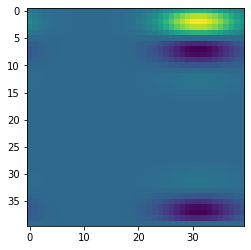

In [80]:
plt.imshow(Gabor_torus)
plt.show()

# 3. Simulate V1 neuron's spike trains in response to stimulus video

### 3(a) Get simulated V1 neuron's response to stimulus video

Compute pixel-wise overlap between each video frame and V1 neuron

In [21]:
train_overlap = compute_video_V1_overlap(train_video, V1_img)
simulation_overlap = compute_video_V1_overlap(simulation_video, V1_img)

100%|██████████| 40000/40000 [17:13<00:00, 38.69it/s]


In [23]:
# print some properties of train_overlap
print("train_overlap shape: ", train_overlap.shape)
print("min: ", np.min(train_overlap))
print("max: ", np.max(train_overlap))

# print some properties of simulation_overlap
print("simulation_overlap shape: ", simulation_overlap.shape)
print("min: ", np.min(simulation_overlap))
print("max: ", np.max(simulation_overlap))

train_overlap shape:  (40000, 800)
min:  -42.66956820283872
max:  57.97769430864825
simulation_overlap shape:  (40000, 800)
min:  -42.66956820283872
max:  57.97769430864825


Maybe take a look at the range of dot products between stimulus and Gabor filters

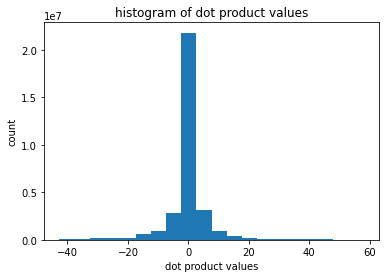

maximum:  57.97769430864825


In [183]:
plt.hist(train_overlap.flatten(), bins = 20)
plt.xlabel("dot product values")
plt.ylabel("count")
plt.title("histogram of dot product values")
plt.show()

print("maximum: ", max(train_overlap.flatten()))

## 3(b) Convert linear filter values values to firing rates via non-linear function

* Use nonlinear tanh function to convert response to firing rate.
* The parameters were chosen so that the resulting rate lies in a reasonable range.
* The parameters of the following may depend on the histogram above

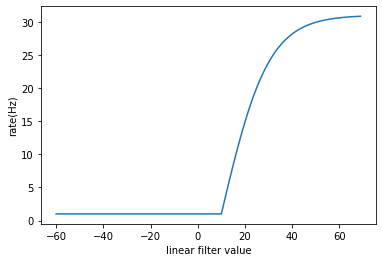

In [174]:
# set parameters of tanh function
r0  = 1 # base rate
L0 = 10
g2 = 0.05
r_max = 30

# using r0 = 1, L0 = 10, g2 = 0.05, r_max = 30 did result in a pretty clean V1 PH in dimension 1

# plot
x = np.array(range(-60, 70))
x_tanh = grm.nonlinear_tanh(g2, L0, r_max, x, r0)
plt.plot(x, x_tanh, label = 'hyperbolic tangent')
plt.xlabel('linear filter value')
plt.ylabel('rate(Hz)')
plt.show()

In [175]:
# get firing rates

train_rate = r0 + grm.nonlinear_tanh(g2, L0, r_max, train_overlap)
simulation_rate = r0 + grm.nonlinear_tanh(g2, L0, r_max, simulation_overlap)

## 3(c) Simulate binary spike trains from the firing rate

In [176]:
# specify bin size
bin_size = 25

# training data
train_binary_raster, _ = simulate_raster(train_rate, bin_size)
# simulation data
simulation_binary_raster, _ = simulate_raster(simulation_rate, bin_size)

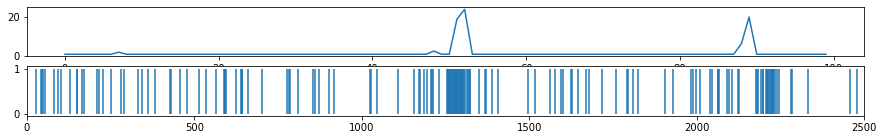

In [177]:
# plot example rate and spike trains
neuron = 5
start = 0
end = 100 # seconds

fig, ax = plt.subplots(nrows = 2, figsize = (15, 2))
# plot rate
ax[0].plot(train_rate[start:end,neuron])
ax[1] = plot_spike_train(train_raster_test[neuron,:], start * bin_size, start * bin_size + end * bin_size)
plt.show()


In [178]:
### save

hf = h5py.File(directory + '/V1_training_rate.h5','w')
hf.create_dataset('rate', data = train_rate)
hf.close()

# save training raster
hf = h5py.File(directory + '/V1_training_raster.h5', 'w')
hf.create_dataset('raster', data = train_binary_raster)
hf.attrs['bin_size'] = bin_size
hf.close()

# save simulation rate
hf = h5py.File(directory + '/V1_simulation_rate.h5', 'w')
hf.create_dataset('rate', data = simulation_rate)
hf.close()

# save simulation raster
hf = h5py.File(directory + '/V1_simulation_raster.h5', 'w')
hf.create_dataset('raster', data = simulation_binary_raster)
hf.attrs['bin_size'] = bin_size
hf.close()
